# Python Statistics Essential training -- Chapter 4

LinkedIn lecture link: https://www.linkedin.com/learning/python-statistics-essential-training/confidence-intervals?autoSkip=true&autoplay=true&leis=LTI&resume=false&u=36492188

In [6]:
''' load packages '''
import math
import io
import os

In [2]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
import scipy.stats
import scipy.optimize
import scipy.spatial

In [4]:
datadir = '../datasets/raw'

## 02 confidence intervals

In [8]:
''' read the file '''

poll = pd.read_csv(os.path.join(datadir,'poll.csv'))

In [9]:
poll.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   vote    1000 non-null   object
dtypes: object(1)
memory usage: 7.9+ KB


In [10]:
poll.head()

,vote
0,Brown
1,Green
2,Brown
3,Brown
4,Brown


In [12]:
poll.vote.value_counts(normalize=True)

Brown    0.511
Green    0.489
Name: vote, dtype: float64

In [13]:
np.random.rand(5)

array([0.15443234, 0.33475033, 0.29106076, 0.69801284, 0.50671197])

In [16]:
# given brwon factor, return the array that includes vote 
def sample(brown, n=1000):
    return pd.DataFrame({'vote': np.where(np.random.rand(n) < brown, 'Brown', 'Green')})

In [18]:
s = sample(0.51, n=1000)
s.vote.value_counts(normalize=True)

Brown    0.536
Green    0.464
Name: vote, dtype: float64

In [19]:
dist = pd.DataFrame([sample(0.51).vote.value_counts(normalize=True) for i in range(1000)])

In [20]:
dist.head()

,Brown,Green
vote,0.503,0.497
vote,0.496,0.504
vote,0.529,0.471
vote,0.517,0.483
vote,0.492,0.508


<AxesSubplot:>

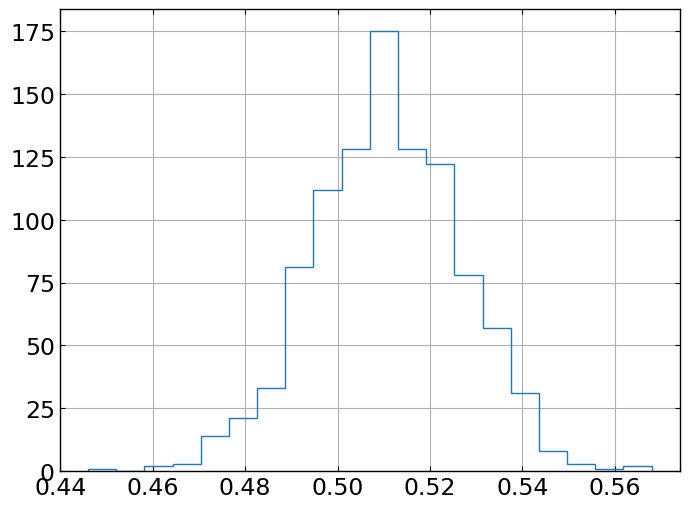

In [21]:
dist.Brown.hist(histtype='step',bins=20)

**Confidence Interval**

**XX\% confidence interval**
- Built from the data
- Contains the true value of a population parameter XX\% of the time
- Over many similar experiments

In [22]:
def samplingdist(brown,n=1000):
    return pd.DataFrame([sample(brown,n).vote.value_counts(normalize=True) for i in range(1000)])

In [24]:
''' qunantiles between 2.5% and 97.5% -> 95% confidence level '''
def quantiles(brown,n=1000):
    dist = samplingdist(brown,n)
    return dist.Brown.quantile(0.025), dist.Brown.quantile(0.975)

In [25]:
quantiles(0.50)

(0.469, 0.531)

In [26]:
quantiles(0.48)

(0.446975, 0.509)

In [28]:
quantiles(0.51)

(0.478, 0.542)

-> 95\% Confidence Interval: [0.48, 0.54]

Estimate = 0.51 $\pm$ 0.03 (at 95% confidence)

where, 0.51 -> Point estimate
       0.03 -> Margin of error
       
**margin of error is anti-proportion to sqare-root of sample size**

In [29]:
dist = samplingdist(0.50,10000)

<AxesSubplot:>

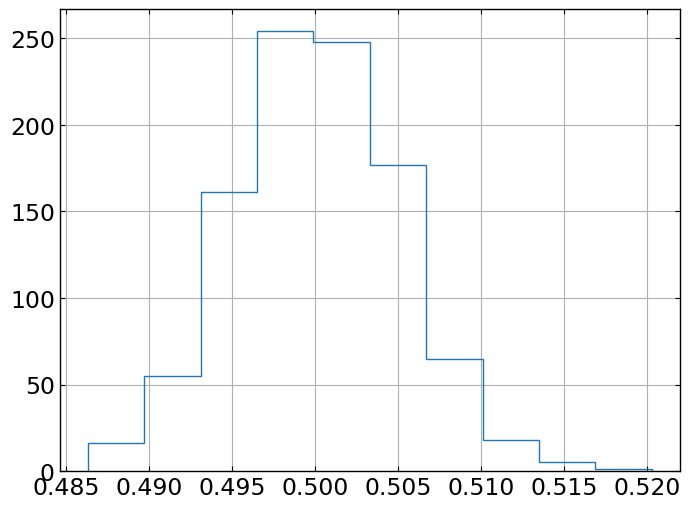

In [30]:
dist.Brown.hist(histtype='step')

In [32]:
largepoll = pd.read_csv(os.path.join(datadir,'poll-larger.csv'))

In [33]:
largepoll.vote.value_counts(normalize=True)

Green    0.5181
Brown    0.4819
Name: vote, dtype: float64

## 03 Bootstrapping

In [36]:
''' read the dataset '''
pop = pd.read_csv(os.path.join(datadir,'grades.csv'))

In [37]:
pop.head()

,grade
0,3.648651
1,5.959915
2,7.387370
3,4.047515
4,2.846912


<AxesSubplot:>

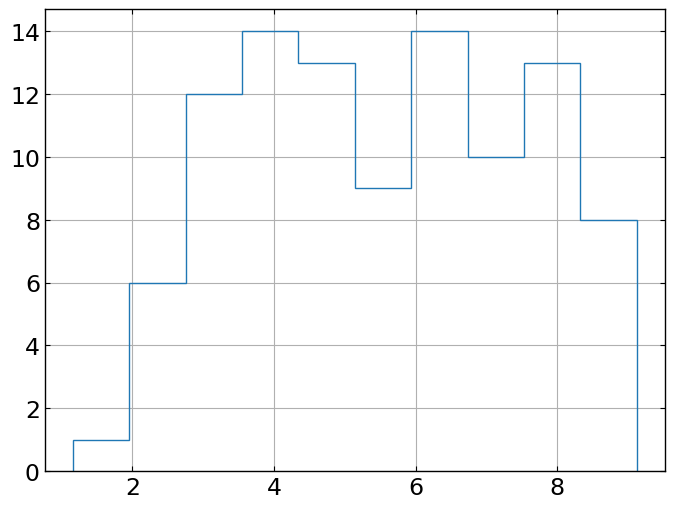

In [38]:
pop.grade.hist(histtype='step')

In [39]:
pop.describe()

,grade
count,100.000000
mean,5.508561
std,1.984988
min,1.160899
25%,3.921372
50%,5.688527
75%,7.272162
max,9.120705


In [8]:
pop.sample(100,replace=True).describe()

,grade
count,100.000000
mean,5.436984
std,2.043781
min,1.160899
25%,3.620426
50%,5.860997
75%,7.132170
max,9.120705


In [42]:
''' sample in pandas '''
pop.sample(100, replace=True).describe()

,grade
count,100.000000
mean,5.748559
std,2.041689
min,1.983167
25%,3.935919
50%,5.908311
75%,7.507273
max,9.120705


In [43]:
bootstrap = pd.DataFrame({'meangrade': [pop.sample(100,replace=True).grade.mean() for i in range(1000)]})

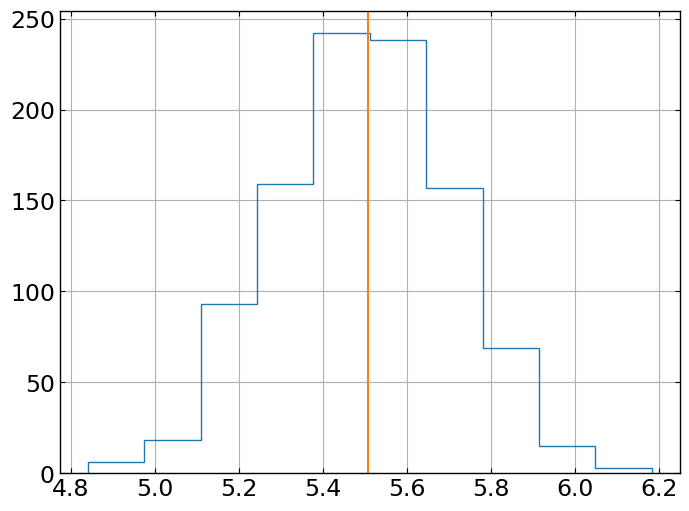

In [45]:
bootstrap.meangrade.hist(histtype='step')
pp.axvline(pop.grade.mean(),color='C1') # Original mean

In [46]:
# quantile for 95% confidence level

bootstrap.meangrade.quantile(0.025), bootstrap.meangrade.quantile(0.975)

(5.120031977333228, 5.880090162026293)

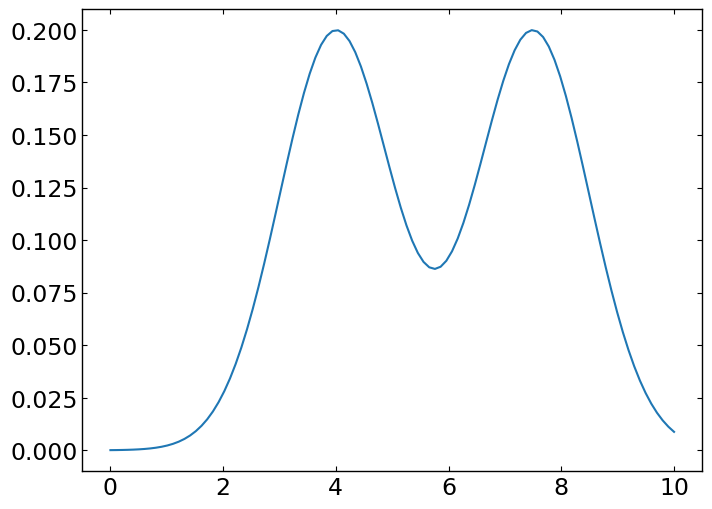

In [48]:
# add up two normal distributions

n1 = scipy.stats.norm(7.5,1)
n2 = scipy.stats.norm(4,1)

x = np.linspace(0,10,100)
pp.plot(x,0.5*n1.pdf(x) + 0.5*n2.pdf(x))   # pdf -> probability density function

In [49]:
def draw():
    while True:
        v = n1.rvs() if np.random.rand() < 0.5 else n2.rvs()
        if 0 <= v <= 10: # truncate
            return v

In [50]:
draw()

8.016676714709865

In [51]:
def dataset(n=100):
    return pd.DataFrame({'grade': [draw() for i in range(n)]})

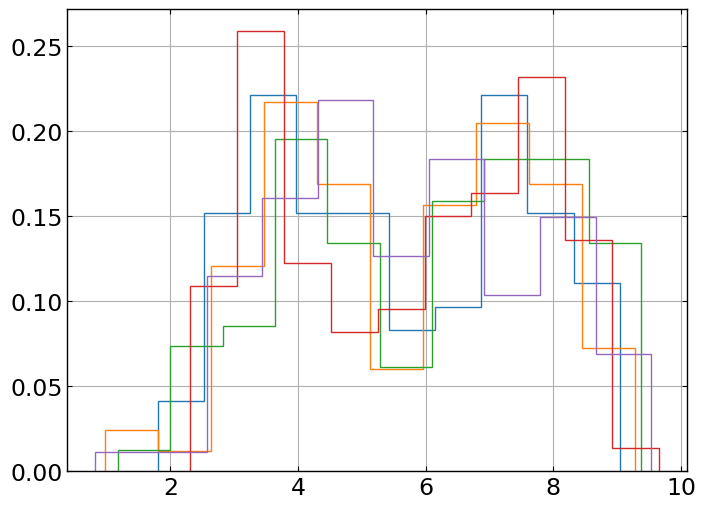

In [52]:
for i in range(5):
    dataset(100).grade.hist(histtype='step',density=True)

In [53]:
means = pd.DataFrame({'meangrade': [dataset(100).grade.mean() for i in range(1000)]})

<AxesSubplot:>

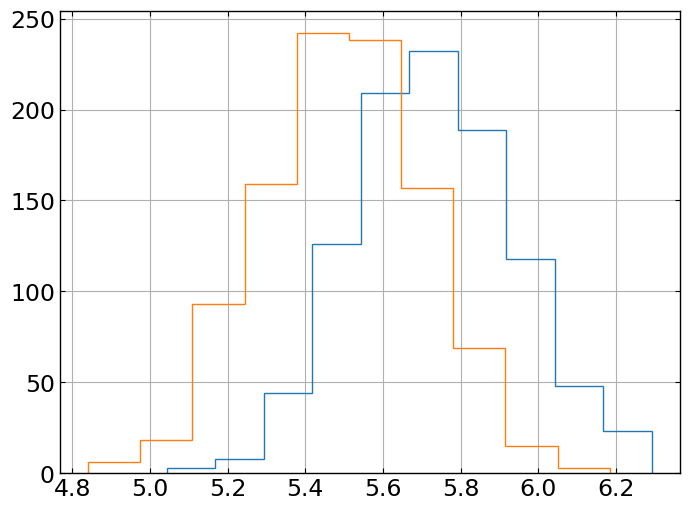

In [54]:
means.meangrade.hist(histtype='step')
bootstrap.meangrade.hist(histtype='step')

## 04 Hypothesis Testing

In [56]:
''' read dataset: position of water pump in london '''
pumps = pd.read_csv(os.path.join(datadir,'pumps.csv'))

In [57]:
pumps

,lat,lon,x,y
0,51.513341,-0.136668,0.000000,0.000000
1,51.513876,-0.139586,-0.201858,0.059469
2,51.514906,-0.139671,-0.207738,0.173961
3,51.512354,-0.131630,0.348513,-0.109712
4,51.512139,-0.133594,0.212650,-0.133611
5,51.511542,-0.135919,0.051813,-0.199972
6,51.510019,-0.133962,0.187193,-0.369265
7,51.511295,-0.138199,-0.105910,-0.227428


In [58]:
cholera = pd.read_csv(os.path.join(datadir,'cholera.csv'))

In [59]:
cholera.loc[0::20]

,deaths,lat,lon,x,y,closest
0,3,51.513418,-0.137930,-0.087301,0.008559,0
20,2,51.513441,-0.138762,-0.144856,0.011116,1
40,2,51.513025,-0.139036,-0.163811,-0.035126,1
60,1,51.512765,-0.137533,-0.059838,-0.064027,0
80,1,51.512782,-0.136819,-0.010446,-0.062137,0
100,4,51.512250,-0.135394,0.088131,-0.121273,5
120,1,51.513238,-0.134594,0.143473,-0.011449,4
140,1,51.512585,-0.134793,0.129707,-0.084035,4
160,1,51.514065,-0.134364,0.159384,0.080478,0
180,1,51.515149,-0.135395,0.088062,0.200973,0


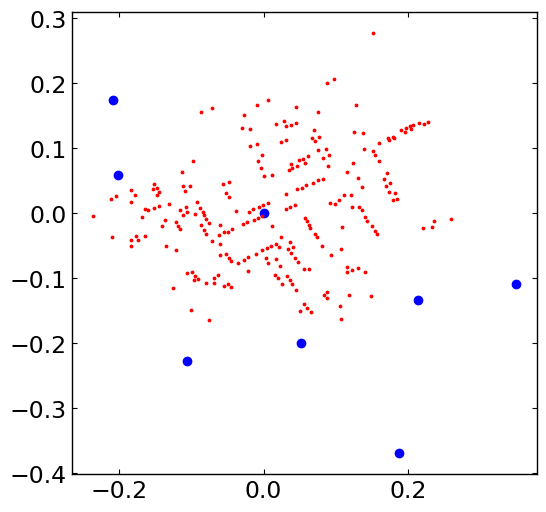

In [60]:
pp.figure(figsize=(6,6))
pp.scatter(pumps.x,pumps.y,color='b')
pp.scatter(cholera.x,cholera.y,color='r',s=3)

In [61]:
img = matplotlib.image.imread(os.path.join(datadir,'london.png'))

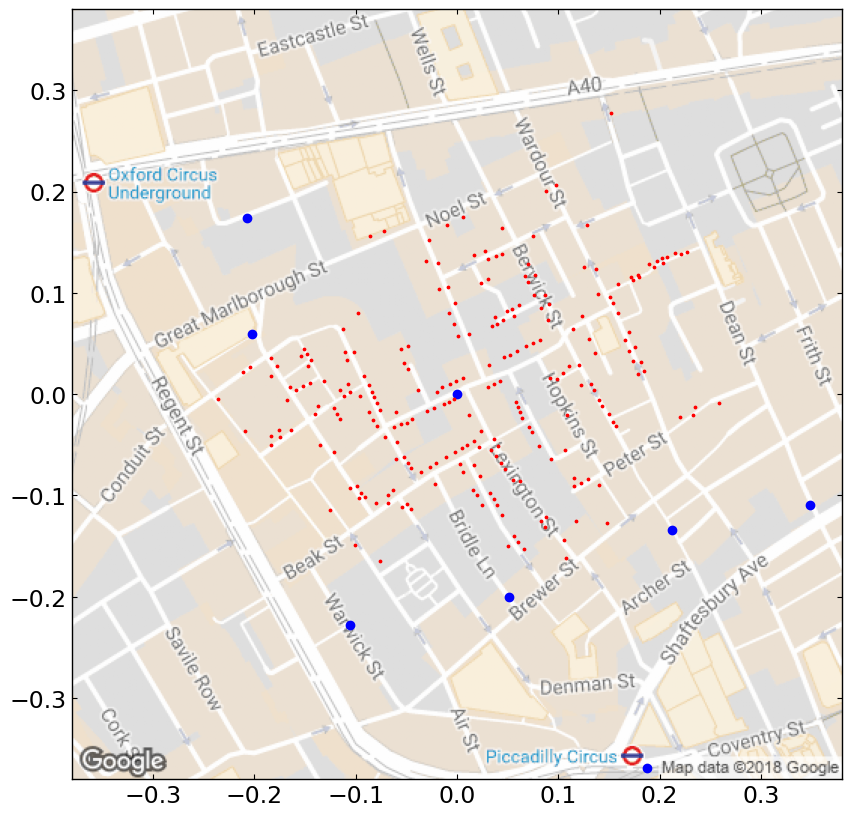

In [62]:
pp.figure(figsize=(10,10))

pp.imshow(img,extent=[-0.38,0.38,-0.38,0.38])  #extent: image size

pp.scatter(pumps.x,pumps.y,color='b')
pp.scatter(cholera.x,cholera.y,color='r',s=3)

In [63]:
cholera.closest.value_counts()

0    171
1     36
4     19
5     13
7      9
2      2
Name: closest, dtype: int64

In [64]:
cholera.groupby('closest').deaths.sum()

closest
0    340
1     65
2      5
4     40
5     27
7     12
Name: deaths, dtype: int64

In [65]:
def simulate(n):
    return pd.DataFrame({'closest': np.random.choice([0,1,4,5],size=n,p=[0.65,0.15,0.10,0.10])})

In [66]:
simulate(489).closest.value_counts()

0    298
1     79
4     58
5     54
Name: closest, dtype: int64

In [67]:
sampling = pd.DataFrame({'counts': [simulate(489).closest.value_counts()[0] for i in range(10000)]})

<AxesSubplot:>

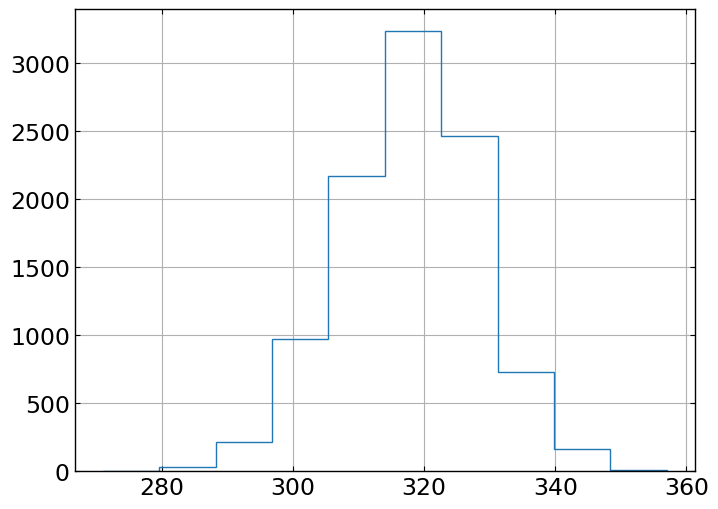

In [68]:
sampling.counts.hist(histtype='step')

In [85]:
# percentile of score: percentage below the value (score)
scipy.stats.percentileofscore(sampling.counts,340)

98.43

In [71]:
100 - 98.14   # p-value

1.8599999999999994

**Null Hypothesis Test**
- Observe statistic in data
- Compute sampling distribution of statistic under null hypothesis
- Quantile of observed statistic gives P-value

## 05 P-values and confidence

Lower P-values -> Higher convidence 

In [72]:
poll = pd.read_csv(os.path.join(datadir, 'poll.csv'))

In [73]:
poll.vote.value_counts(normalize=True)

Brown    0.511
Green    0.489
Name: vote, dtype: float64

In [74]:
def sample(brown, n=1000):
    return pd.DataFrame({'vote': np.where(np.random.rand(n) < brown,'Brown','Green')})

In [75]:
dist = pd.DataFrame({'Brown': [sample(0.50,1000).vote.value_counts(normalize=True)['Brown'] for i in range(10000)]})

<AxesSubplot:>

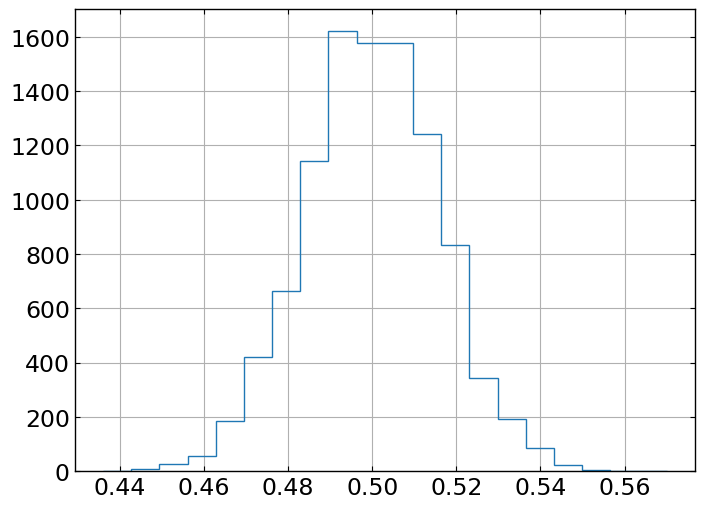

In [76]:
dist.Brown.hist(histtype='step',bins=20)

In [77]:
100 - scipy.stats.percentileofscore(dist.Brown,0.511)   # corresponding p-value

24.265

not low enough to reject the null hypothesis

In [78]:
largepoll = pd.read_csv(os.path.join(datadir,'poll-larger.csv'))

In [79]:
largepoll.vote.value_counts(normalize=True)

Green    0.5181
Brown    0.4819
Name: vote, dtype: float64

In [80]:
dist = pd.DataFrame({'Green': [sample(0.50,10000).vote.value_counts(normalize=True)['Green'] for i in range(1000)]})

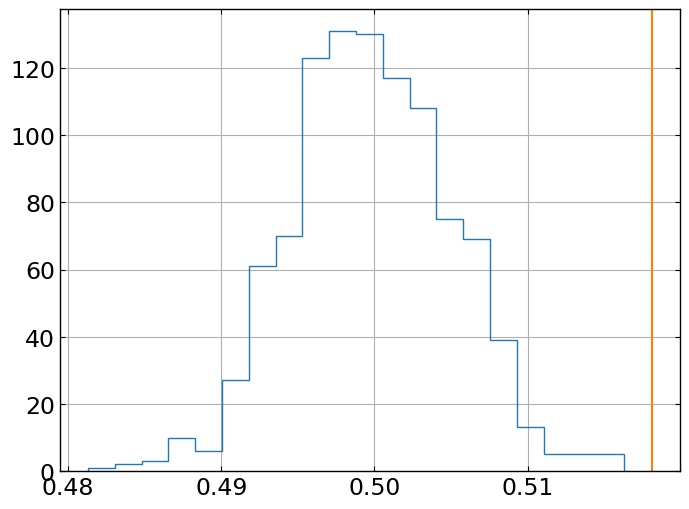

In [81]:
dist.Green.hist(histtype='step',bins=20)
pp.axvline(0.5181,c='C1')

null hypothesis should be rejected as the data is out of confidence interval
--> statistically significant

## 07 Challenge solution

In [86]:
pop = pd.read_csv(os.path.join(datadir,'grades.csv'))

<AxesSubplot:>

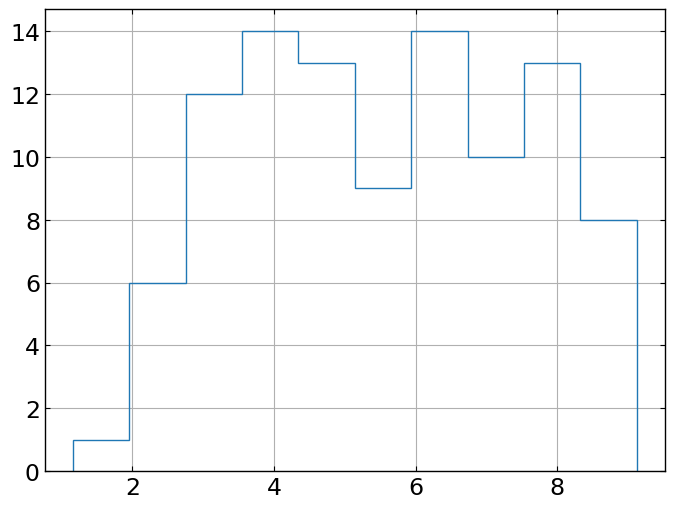

In [87]:
pop.grade.hist(histtype='step')

In [88]:
scipy.stats.percentileofscore(pop.grade,5)

43.0

In [89]:
# Modelling

bootstrap = pd.DataFrame({'passing': [scipy.stats.percentileofscore(pop.sample(100,replace=True).grade,5) for i in range(1000)]})

<AxesSubplot:>

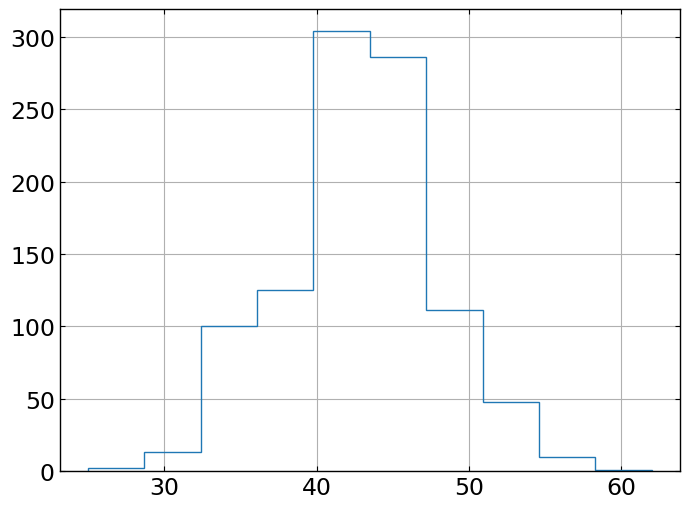

In [90]:
bootstrap.passing.hist(histtype='step')

In [91]:
bootstrap.passing.quantile(0.025), bootstrap.passing.quantile(0.975)

(33.0, 53.0)